This code is modified from the code at the below link.

https://github.com/Ryanfras/Customer-Visits

# Predicting customer visits
## Introduction
We are tasked with predicting which day of the week our customers will visit a shopping mall again. This notebook details the steps taken to solve this problem. We have a dataset with weekly visits of ~70,000 customers. We will use data from 10,000 customers so that we don't exceed Google Colab's memory quota.

## Dataset description
Each line represents one customer - the first column contains unique customer
identifier and the second column contains indices of the day when customer have visited the mall. The day
with index 1 is a Monday (e. g. 7th is a Sunday, 8th is again a Monday). Indices are within a range of 1 to 1001
(which is equal to 143 full weeks). The task is to predict the first day of the next visit (week 144). For example,
if customer will visit mall on Wednesday, then prediction should be equal to 3:
0. Customer will not visit on the next week
1. Monday
2. Tuesday
3. Wednesday
4. Thursday
5. Friday
6. Saturday
7. Sunday

### Data Preparation

The following steps are taken to prepare our data for machine learning:
- Transform data from wide to long format
- Create dummy variables for each day of week
- Aggregate to weekly.
- Feature engineering
    - Total number of visits (Freq)
    - Weeks since previous visit
    - No visits (dow_0) 
    - Total number of visits for each day of week (tot_dow_0 - tot_dow_7)
    - Proportion of total visits for each day of week (prop_dow_0 - prop_dow_7)
Note - We can also include some exogenous variables like weather or holiday for feature engineering if we believe those variables would help in predicting a customer's visit to a mall. However, we don't have those available here.

### Modeling Approach

We use Random forests because they are easy to implement, give feature importance and can be top performers if tuned correctly. 

To solve this classification problem we are going to:
- Treat each day as a binary classification problem. This will give us the probably of a customer visiting a spesific day in a spesific week. Hence we will have 8 binary classification models (7 days of the week + 0 for no visit)
- Use the highest predicted value for each customer and use that as the prediction for the following week
  
## Data Import and Prep

First we need to import the data to see what the structure looks like

### Import Data

Run with different number of customers. Set the value of Num_Customers to 1000, 5000 and then 10000. See how the results change as we get more data.

In [1]:
import pandas as pd
import numpy as np

FILE = 'https://raw.githubusercontent.com/firmai/python-business-analytics/master/data/customer/train_set.csv'

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

df_raw = pd.read_csv(FILE)
Num_Customers = 10000 # We only use data of 1000 customers so that our memory usage doesn't exceed Free Colab's quota.
df_raw = df_raw.head(Num_Customers) 
df_raw.columns = df_raw.columns.str.strip()
df_raw.head()


,visitor_id,visits
0,1,30 84 126 135 137 179 242 342 426 456 460 462...
1,2,24 53 75 134 158 192 194 211 213 238 251 305 ...
2,3,51 143 173 257 446 491 504 510 559 616 719 73...
3,4,1 20 22 92 124 149 211 335 387 390 406 460 48...
4,5,34 51 56 106 110 121 163 233 266 275 345 359 ...


Now we can focus on restructuring the visits to a more appropriate format.

In [2]:
visits_df = (df_raw['visits']
     .str.strip() # remove leading and trailing white splace
     .str.split(' ', expand = True) # split the visits into a python lists
    
)

# merge this data to the original data
# %%time
df_raw1 = (df_raw.merge(visits_df, right_index = True, left_index = True) # merge the original data with the expanded visits
                .drop(['visits'], axis=1) # drop the origil visits columns
                .melt(id_vars = ['visitor_id'], value_name = "visit_day") # transform from wide format to long format
                .drop("variable", axis = 1) # drop variable column which was added by melt function
                .dropna() # drop the missing entries
            )

df_raw1['visit_day'] = df_raw1['visit_day'].astype('int')
df_raw1 = (df_raw1.sort_values(['visitor_id', 'visit_day'])
                .reset_index(drop = True) # drop the old index
          )
df_raw1.head()

,visitor_id,visit_day
0,1,30
1,1,84
2,1,126
3,1,135
4,1,137


In [3]:
df_raw1.to_feather('df_raw')

# Delete all the unused object from memory.

del visits_df 
del df_raw
del df_raw1


## Exploratory Data Analysis

In [4]:
df = pd.read_feather('df_raw')
# Convert the types to reduce memory usage

df['visitor_id'] = df['visitor_id'].astype(np.uint32)
df['visit_day'] = df['visit_day'].astype(np.uint32)

# Adding the day of week to the dataset

def add_day_of_week(index): 
    return (index) % 7

df.loc[df['visitor_id'] == 4].head() # Visitor 4 visited the first day so we can validate whether day_of_week = 1 (Monday)

,visitor_id,visit_day
81,4,1
82,4,20
83,4,22
84,4,92
85,4,124


In [5]:
df['day_of_week'] = df['visit_day'].apply(add_day_of_week) # add new column for day of week
df.loc[df['day_of_week'] == 0, 'day_of_week'] = 7 # set all the 0's to 7 (Sunday)
df['day_of_week'] = df['day_of_week'].astype(np.uint8) # convert to uint8 to save memory
df.loc[df['visitor_id'] == 4].head()

,visitor_id,visit_day,day_of_week
81,4,1,1
82,4,20,6
83,4,22,1
84,4,92,1
85,4,124,5


In [6]:
df['day_of_week'].value_counts()

7    84699
6    78587
2    76088
1    73495
3    70804
5    64719
4    62625
Name: day_of_week, dtype: int64

It seems that the weekends (6 & 7) are the most popular days to visit the mall

In [7]:
df['week_number'] = (np.floor((df['visit_day']-1) / 7) + 1).astype(np.uint32) # Through some trial and error I found this works
df.to_feather('df')

## Approach

To solve this classification problem we are going to:
- Create dummy variables for each day of week
- Aggregate this time series to weekly. We want to predict the next week.
- Do feature engineering
- Treat each day as a binary classification problem. This will give us the probably of a customer visiting a specific day in a specific week. Hence we will have 8 binary classification models (7 days of the week + 0 for no visit)
- Use the highest predicted value for each customer and use that as the prediction for the following week

### Get dummy variables

In [8]:
df = pd.read_feather('df')
dow_dummies = pd.get_dummies(df['day_of_week'], prefix='dow')

# Now we join back dummies to original data
df = df.merge(dow_dummies, left_index = True, right_index = True)
df.head()

,visitor_id,visit_day,day_of_week,week_number,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
0,1,30,2,5,0,1,0,0,0,0,0
1,1,84,7,12,0,0,0,0,0,0,1
2,1,126,7,18,0,0,0,0,0,0,1
3,1,135,2,20,0,1,0,0,0,0,0
4,1,137,4,20,0,0,0,1,0,0,0


### Aggregate to weekly

In [9]:
%%time
df_w = df.groupby(['visitor_id', 'week_number']).agg({'dow_1':sum,
                                                           'dow_2':sum, 
                                                           'dow_3':sum,
                                                           'dow_4':sum,
                                                           'dow_5':sum,
                                                           'dow_6':sum,
                                                           'dow_7':sum
                                                          })

CPU times: user 562 ms, sys: 24.5 ms, total: 587 ms
Wall time: 783 ms


In [10]:
df_w.head()

dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7
visitor_id week_number                                                 
1          5                0      1      0      0      0      0      0
           12               0      0      0      0      0      0      1
           18               0      0      0      0      0      0      1
           20               0      1      0      1      0      0      0
           26               0      0      0      1      0      0      0

In [11]:
df_w = df_w.reset_index()

### Account for no visit

Currently our dataset only contains weeks in which a customer made a visit. We need to add additional weeks to the data to represent those weeks where no visit happaned. We can do this by doing a full outer join on a full range of weeks for every customer

The next step creates the full range. We do this by:
- Create a range from 1:Num_Customers to represent visitor_id's
- Repeat every visitor id 143 times to get the full range of weeks for every visitor id
- Set a tempory record = 1
- Use the cumsum of this tempory record to get the week integer values

In [12]:
visitor_ids = pd.Series(range(1, Num_Customers))
visitor_ids_rep = visitor_ids.repeat(143).reset_index(drop=True)
full_range = pd.DataFrame({'visitor_id': visitor_ids_rep})
full_range['record'] = 1
full_range['week_number'] = full_range.groupby('visitor_id')['record'].cumsum()
full_range['visitor_id'] = full_range['visitor_id'].astype(np.uint64)
full_range['week_number'] = full_range['week_number'].astype(np.uint64)

Do the full outer join on the weekly data

In [13]:
%%time
df_w1 = df_w.merge(full_range[['visitor_id','week_number']], 
                  left_on=['visitor_id','week_number'], 
                  right_on=['visitor_id','week_number'], 
                  how = 'outer')
df_w1 = df_w1.sort_values(['visitor_id', 'week_number'])

CPU times: user 1.01 s, sys: 156 ms, total: 1.16 s
Wall time: 1.56 s


In [14]:
df_w1 = df_w1.fillna(0) # set NaN values to 0

#### total_visits_in_week

Next we create a new column to represent the total number of visits in a spesific week

In [15]:
dow_cols = df_w1.columns[df_w1.columns.str.contains('dow')]
df_w1['total_visits_in_week'] = df_w1[dow_cols].sum(axis=1)
df_w1.tail()

,visitor_id,week_number,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,total_visits_in_week
441868,10000,132,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
441869,10000,133,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
441870,10000,135,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
441871,10000,136,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
441872,10000,143,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0


In [16]:
# Downcast the values stored as float64 to uint8 to save memory

df_w1_float = df_w1.select_dtypes(include=['float']).columns
df_w1[df_w1_float] = df_w1[df_w1_float].apply(pd.to_numeric, downcast='unsigned')

In [17]:
df_w1 = df_w1.reset_index(drop=True)

Let's store this as a feather file to save our progress

In [18]:
df_w1.to_feather('df_w')

And del all the unused object from memory

In [19]:
del df
del df_w
del full_range
del visitor_ids
del visitor_ids_rep

### Freq

We can create the frequency of visits and a specific point in time by taking the cumulative sum of total_visits_per_week for each visitor

In [20]:
df_w1['freq'] = df_w1.groupby('visitor_id')['total_visits_in_week'].cumsum().astype(np.uint32)

We will remove all the weeks where the customer freq = 0 i.e. the first visit hasn't happened yet

In [21]:
df_w2 = df_w1.loc[~(df_w1['freq'] == 0)].reset_index(drop = True)
df_w2.shape

(1406836, 11)

In [22]:
del df_w1

In [23]:
df_w2.tail(5)

,visitor_id,week_number,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,total_visits_in_week,freq
1406831,10000,132,0,0,1,0,0,0,0,1,53
1406832,10000,133,0,1,0,0,0,0,0,1,54
1406833,10000,135,0,0,0,0,1,0,0,1,55
1406834,10000,136,0,0,1,0,0,0,0,1,56
1406835,10000,143,0,1,0,1,0,0,0,2,58


### any_visit_ind

We create a column which tells us whether a visit (on any day) happaned

In [24]:
df_w2['any_visit_ind'] = (df_w2['total_visits_in_week'] > 0).astype(np.uint8)
df_w2.head()

,visitor_id,week_number,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,total_visits_in_week,freq,any_visit_ind
0,1,5,0,1,0,0,0,0,0,1,1,1
1,1,6,0,0,0,0,0,0,0,0,1,0
2,1,7,0,0,0,0,0,0,0,0,1,0
3,1,8,0,0,0,0,0,0,0,0,1,0
4,1,9,0,0,0,0,0,0,0,0,1,0


### dow_0

The rows which represent no visit is just 1 - any_vist_ind

In [25]:
df_w2['dow_0'] = 1 - df_w2['any_visit_ind']

### weeks_since_previous_visit

Your previous visit will probably effect your next visit so lets get weeks_since_previous_visit

In [26]:
%%time
weeks_since_prev_visit = []
for r in df_w2['any_visit_ind']:
    if r == 1.0:
        c=1.0
    else:
        c+=1.0
    weeks_since_prev_visit.append(c)

CPU times: user 913 ms, sys: 39.7 ms, total: 953 ms
Wall time: 1.27 s


In [27]:
weeks_since_prev_visit = pd.DataFrame({'weeks_since_prev_visit':weeks_since_prev_visit})

In [28]:
df_w2 = pd.concat([df_w2, weeks_since_prev_visit], axis=1)

In [29]:
df_w2['weeks_since_prev_visit'] = df_w2['weeks_since_prev_visit'].astype(np.uint32)

In [30]:
df_w2.head(5)

,visitor_id,week_number,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,total_visits_in_week,freq,any_visit_ind,dow_0,weeks_since_prev_visit
0,1,5,0,1,0,0,0,0,0,1,1,1,0,1
1,1,6,0,0,0,0,0,0,0,0,1,0,1,2
2,1,7,0,0,0,0,0,0,0,0,1,0,1,3
3,1,8,0,0,0,0,0,0,0,0,1,0,1,4
4,1,9,0,0,0,0,0,0,0,0,1,0,1,5


In [31]:
df_w2.to_feather('df_w2')

### tot_dow

Get the total number of visits for a specific day_of_week. The reasoning for this feature: Someone who has visited on Monday often is likely to visit on Monday again.

In [32]:
%%time
df_w2['tot_dow_0'] = df_w2.groupby('visitor_id')['dow_0'].cumsum().astype(np.uint32)
df_w2['tot_dow_1'] = df_w2.groupby('visitor_id')['dow_1'].cumsum().astype(np.uint32)
df_w2['tot_dow_2'] = df_w2.groupby('visitor_id')['dow_2'].cumsum().astype(np.uint32)
df_w2['tot_dow_3'] = df_w2.groupby('visitor_id')['dow_3'].cumsum().astype(np.uint32)
df_w2['tot_dow_4'] = df_w2.groupby('visitor_id')['dow_4'].cumsum().astype(np.uint32)
df_w2['tot_dow_5'] = df_w2.groupby('visitor_id')['dow_5'].cumsum().astype(np.uint32)
df_w2['tot_dow_6'] = df_w2.groupby('visitor_id')['dow_6'].cumsum().astype(np.uint32)
df_w2['tot_dow_7'] = df_w2.groupby('visitor_id')['dow_7'].cumsum().astype(np.uint32)

CPU times: user 596 ms, sys: 29.9 ms, total: 626 ms
Wall time: 775 ms


In [33]:
display_all(df_w2.head())

,visitor_id,week_number,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,total_visits_in_week,freq,any_visit_ind,dow_0,weeks_since_prev_visit,tot_dow_0,tot_dow_1,tot_dow_2,tot_dow_3,tot_dow_4,tot_dow_5,tot_dow_6,tot_dow_7
0,1,5,0,1,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0
1,1,6,0,0,0,0,0,0,0,0,1,0,1,2,1,0,1,0,0,0,0,0
2,1,7,0,0,0,0,0,0,0,0,1,0,1,3,2,0,1,0,0,0,0,0
3,1,8,0,0,0,0,0,0,0,0,1,0,1,4,3,0,1,0,0,0,0,0
4,1,9,0,0,0,0,0,0,0,0,1,0,1,5,4,0,1,0,0,0,0,0


### prop_dow

We can get the day_of_week proportion of their total visits by just dividing with freq. Reasoning: If someone has visited 10 times and 9 out of 10 were on Sunday, they are likely to visit again on a Sunday. Non visits is calculated slightly differently because we want the proportion of non visits of out the full timerange

In [34]:
df_w2['prop_dow_0'] = pd.to_numeric(df_w2['tot_dow_0'] / (df_w2['freq'] + df_w2['tot_dow_0']), downcast = 'float')
df_w2['prop_dow_1'] = pd.to_numeric(df_w2['tot_dow_1'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_2'] = pd.to_numeric(df_w2['tot_dow_2'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_3'] = pd.to_numeric(df_w2['tot_dow_3'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_4'] = pd.to_numeric(df_w2['tot_dow_4'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_5'] = pd.to_numeric(df_w2['tot_dow_5'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_6'] = pd.to_numeric(df_w2['tot_dow_6'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_7'] = pd.to_numeric(df_w2['tot_dow_7'] / df_w2['freq'], downcast = 'float')

Finally we need to shift all the features to the next time period. When we are predicting we are going to use the previous week information to predict this week

In [35]:
df_w2.to_feather('df_w2')

In [36]:
df_w2 = pd.read_feather('df_w2')

## Model Building Prep

Finally, we can start the fun part. I decided to use random forest to solve each binary classification. Why only RF? RF is a fairly robust algorithm which has proven to be a top performer in most modelling problems. I also do not have time to try many different models.

In [37]:
df = pd.read_feather('df_w2')

In [38]:
df.shape

(1406836, 30)

For the training set we will use the weeks spanning 130-140. These weeks are closest to the test and validation sets. The valid, test and final test will be the last 3 weeks in our data. I didn't need to make test_final but decided it would be better to have another test to make sure the model is generalizing well 

In [39]:
test_final = df.loc[df['week_number'] == 143]
test = df.loc[df['week_number'] == 142]
valid = df.loc[df['week_number'] == 141]
train = df.loc[df['week_number'].isin(range(130, 141))]

In [40]:
print(test.shape)
print(test_final.shape)
print(valid.shape)
print(train.shape)

(9999, 30)
(10000, 30)
(9999, 30)
(109993, 30)


In [41]:
features_tot_dow = list(df.columns[df.columns.str.contains('tot_dow')].values)
features_prop_dow = list(df.columns[df.columns.str.contains('prop_dow')].values)
features_other = ['freq', 'weeks_since_prev_visit']
features = []
features.extend(features_tot_dow)
features.extend(features_prop_dow)
features.extend(features_other)

I have removed the below features after investigating the plots in the next section. 

In [42]:
features.remove('tot_dow_0') # correlated with prop_dow_0
features.remove('freq') # correlated with prop_dow_0

In [43]:
targets = ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7']

In [44]:
X_train_full = train[features]
y_train_full = train[targets]
X_valid = valid[features]
y_valid = valid[targets]
X_test = test[features]
y_test = test[targets]
X_test_final = test_final[features]
y_test_final = test_final[targets]

In [45]:
display_all(X_train_full.tail())

,tot_dow_1,tot_dow_2,tot_dow_3,tot_dow_4,tot_dow_5,tot_dow_6,tot_dow_7,prop_dow_0,prop_dow_1,prop_dow_2,prop_dow_3,prop_dow_4,prop_dow_5,prop_dow_6,prop_dow_7,weeks_since_prev_visit
1406779,5,9,12,4,18,9,3,0.577465,0.083333,0.150000,0.200000,0.066667,0.300000,0.150000,0.050000,2
1406831,9,9,18,0,8,8,1,0.000000,0.169811,0.169811,0.339623,0.000000,0.150943,0.150943,0.018868,1
1406832,9,10,18,0,8,8,1,0.000000,0.166667,0.185185,0.333333,0.000000,0.148148,0.148148,0.018519,1
1406833,9,10,18,0,9,8,1,0.000000,0.163636,0.181818,0.327273,0.000000,0.163636,0.145455,0.018182,1
1406834,9,10,19,0,9,8,1,0.000000,0.160714,0.178571,0.339286,0.000000,0.160714,0.142857,0.017857,1


In [46]:
y_train_full.tail()

,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
1406779,1,0,0,0,0,0,0,0
1406831,0,0,0,1,0,0,0,0
1406832,0,0,1,0,0,0,0,0
1406833,0,0,0,0,0,1,0,0
1406834,0,0,0,1,0,0,0,0


### Stardardize feature set

In [47]:
from sklearn.preprocessing import StandardScaler

vali = 1515
sample_index = X_train_full.sample(vali).index

#X_train = X_train_full.loc[sample_index]
#y_train = y_train_full.loc[sample_index]

X_train = X_train_full
y_train = y_train_full

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_test_final = scaler.transform(X_test_final)

## Model Building

We will be looking at scores all the time to compare different parameter settings so it is much easier to wrap this in a function

In [48]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

from sklearn import metrics

def print_score(m, dow):
    res = [rmse(m.predict(X_train), y_train[dow]), 
           rmse(m.predict(X_valid), y_valid[dow]),
           m.score(X_train, y_train[dow]), 
           m.score(X_valid, y_valid[dow])]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Random Forest

In [49]:
# !pip install sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import _forest
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def get_feature_importance(m):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(features, m.feature_importances_):
        feats[feature] = importance #add the name/value pair 
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
    importances = importances.sort_values(by='Importance')
    return importances

In [50]:
print(X_train.shape)
print(y_train.shape)

(109993, 16)
(109993, 8)


In [51]:
train.week_number.unique()

array([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140],
      dtype=uint64)

### Running the Models

In [52]:
rf_models = {}

for target in targets:
    rf_classifier = RandomForestClassifier(n_estimators = 80, 
                                           max_features=0.1, 
                                           min_samples_leaf=3, 
                                           n_jobs = -1, 
                                           oob_score=True, 
                                           class_weight='balanced')
    rf_classifier.fit(X_train, y_train[target])
    print(target)
    print_score(rf_classifier, target)
    rf_models[target] = rf_classifier  

dow_0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0.0, 0.0, 1.0, 1.0, 0.9998090787595574]
dow_1


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0.09601441801669304, 0.2681551616491316, 0.9907812315329158, 0.9280928092809281, 0.9326229850990517]
dow_2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0.10247276820863944, 0.2705685139332979, 0.9894993317756584, 0.9267926792679267, 0.9298864473193749]
dow_3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0.09606175073734806, 0.2580826624670216, 0.9907721400452756, 0.9333933393339334, 0.9358504632112953]
dow_4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0.08262994141188797, 0.2494117491660371, 0.9931722927822679, 0.9377937793779378, 0.9410598856290855]
dow_5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0.08506952545734314, 0.2482058835242662, 0.9927631758384624, 0.9383938393839384, 0.9402689262043948]
dow_6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0.10821199601004432, 0.2751500876922915, 0.9882901639195222, 0.9242924292429243, 0.9279317774767485]
dow_7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0.1118882410284868, 0.27786277327500564, 0.9874810215195512, 0.9227922792279228, 0.9225223423308756]


In [53]:
rf_models

{'dow_0': RandomForestClassifier(class_weight='balanced', max_features=0.1,
                        min_samples_leaf=3, n_estimators=80, n_jobs=-1,
                        oob_score=True),
 'dow_1': RandomForestClassifier(class_weight='balanced', max_features=0.1,
                        min_samples_leaf=3, n_estimators=80, n_jobs=-1,
                        oob_score=True),
 'dow_2': RandomForestClassifier(class_weight='balanced', max_features=0.1,
                        min_samples_leaf=3, n_estimators=80, n_jobs=-1,
                        oob_score=True),
 'dow_3': RandomForestClassifier(class_weight='balanced', max_features=0.1,
                        min_samples_leaf=3, n_estimators=80, n_jobs=-1,
                        oob_score=True),
 'dow_4': RandomForestClassifier(class_weight='balanced', max_features=0.1,
                        min_samples_leaf=3, n_estimators=80, n_jobs=-1,
                        oob_score=True),
 'dow_5': RandomForestClassifier(class_weight='balanced

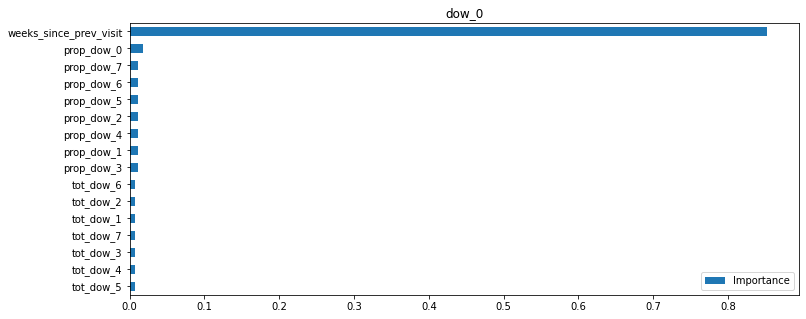

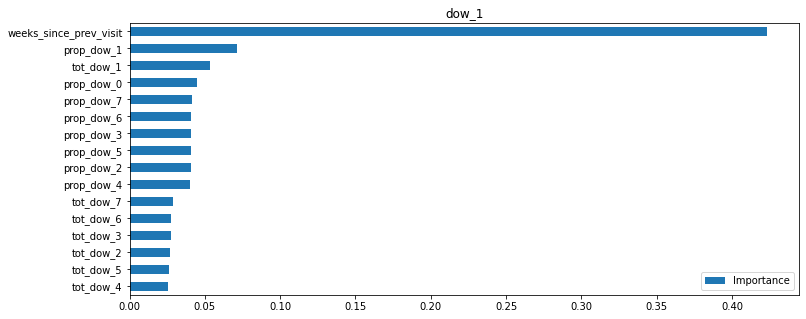

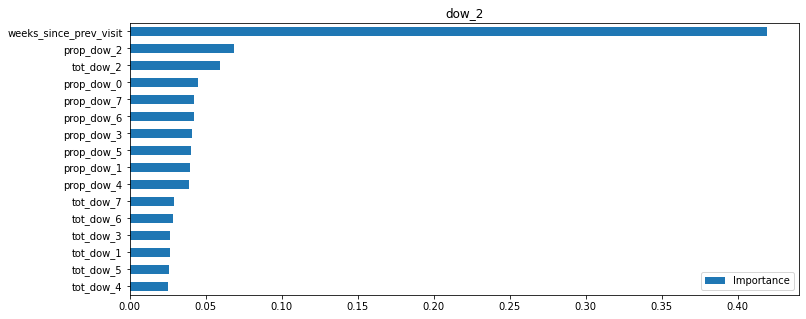

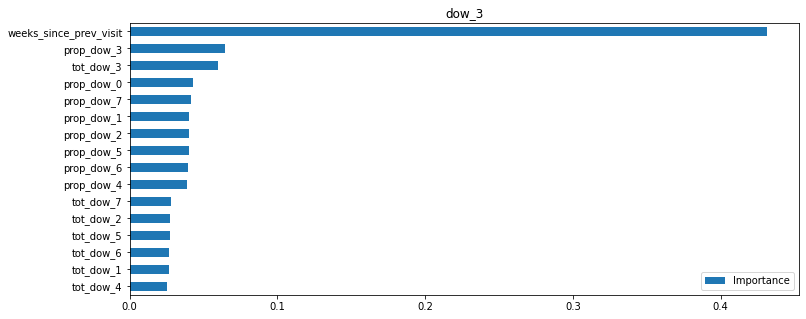

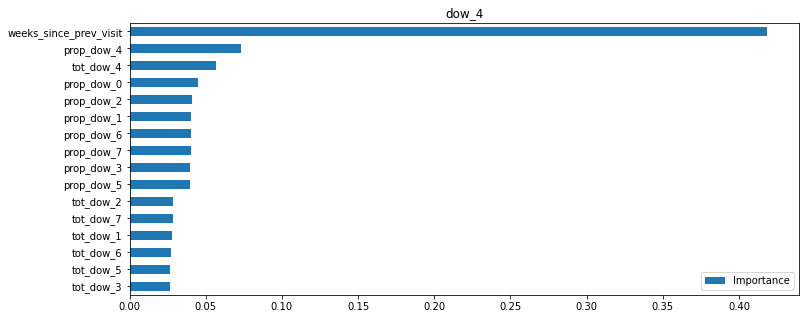

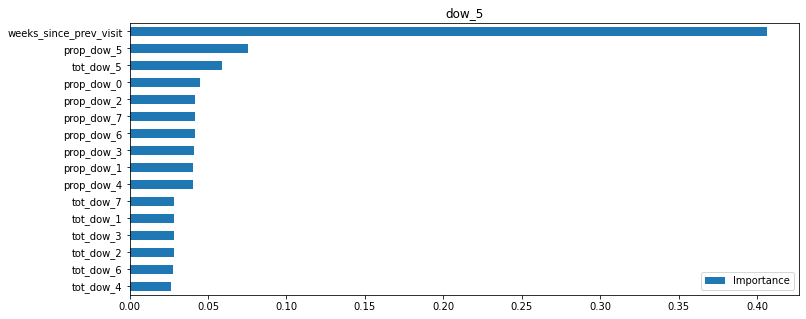

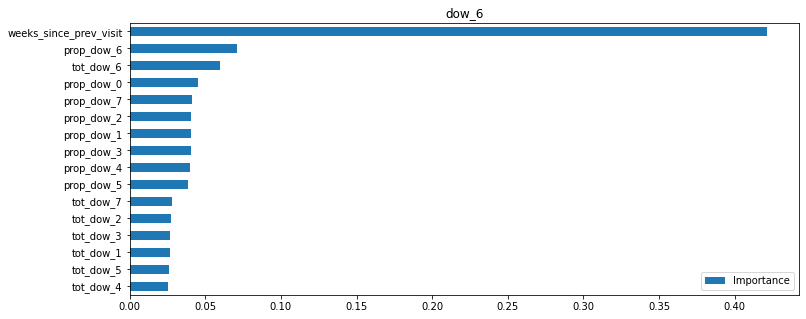

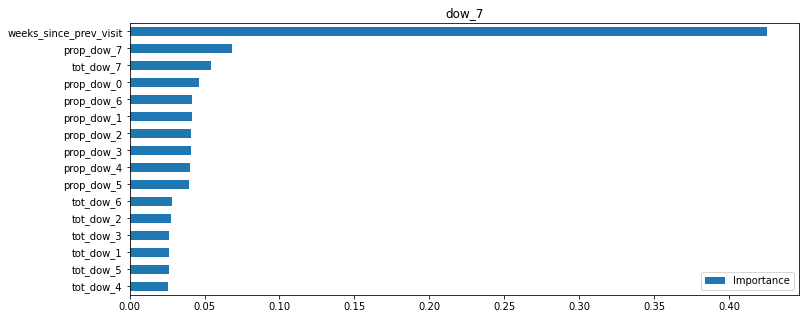

In [54]:
for dow, m in rf_models.items():
    get_feature_importance(m).plot(kind='barh', figsize=(12,5), title=dow) 

In [55]:
train_probs = pd.DataFrame(columns=targets) 
valid_probs = pd.DataFrame(columns=targets)
test_probs = pd.DataFrame(columns=targets)
test_final_probs = pd.DataFrame(columns=targets)

for target in targets:
    # Compute probability of observation being in the origin.
    train_probs[target] = rf_models[target].predict_proba(X_train)[:,1]
    valid_probs[target] = rf_models[target].predict_proba(X_valid)[:,1]
    test_probs[target] = rf_models[target].predict_proba(X_test)[:,1]
    test_final_probs[target] = rf_models[target].predict_proba(X_test)[:,1]    

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

### Tableau dataset

In [56]:
train_viz = pd.concat([train.reset_index(drop=True), train_probs], axis=1)
valid_viz = pd.concat([valid.reset_index(drop=True), valid_probs], axis=1)
test_viz = pd.concat([test.reset_index(drop=True), test_probs], axis=1)
test_final_viz = pd.concat([test_final.reset_index(drop=True), test_final_probs], axis=1)

In [57]:
train_viz['set'] = 'train'
valid_viz['set'] = 'valid'
test_viz['set'] = 'test'
test_final_viz['set'] = 'test_final'

In [58]:
all_viz = pd.concat([train_viz, valid_viz, test_viz, test_final_viz], axis=0)

In [59]:
all_viz.shape

(139991, 39)

### Check test prediction

In [60]:
test[targets].tail()

,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
1406220,1,0,0,0,0,0,0,0
1406363,0,0,0,0,0,1,0,0
1406503,1,0,0,0,0,0,0,0
1406645,1,0,0,0,0,0,0,0
1406781,1,0,0,0,0,0,0,0


In [61]:
test_probs.tail()

,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
9994,0.927755,0.127956,0.076208,0.000000,0.062059,0.010081,0.035705,0.040005
9995,0.087027,0.298933,0.497841,0.287201,0.283375,0.371084,0.138495,0.184985
9996,0.850557,0.110853,0.011427,0.011335,0.000000,0.009032,0.075544,0.064254
9997,0.923036,0.011049,0.029003,0.024609,0.023226,0.000000,0.145549,0.113751
9998,0.817275,0.032308,0.030627,0.091065,0.135412,0.061968,0.140798,0.046783


In [62]:
predicted_day = test_probs.idxmax(axis=1)
predicted_day.tail()

9994    dow_0
9995    dow_2
9996    dow_0
9997    dow_0
9998    dow_0
dtype: object

## Conclusion

Credit: [Ryan Fras](https://github.com/Ryanfras)

Repository: [Customer Visit](https://github.com/Ryanfras/Customer-Visits)
